--- raw data	
448 448
--- curve1	
Exponential function regression - MSE: 670.53, RMSE: 25.89, MAE: 19.51, R²:0.00
最优化参数: [1.09213301e+14 1.49180761e+02 2.63319977e+01]
--- curve2	
Power function regression - MSE: 631.82, RMSE: 25.14, MAE: 18.85, R²:0.06
最优化参数: [-0.86062717  8.05212799 12.48854458]
--- curve3	
Linear regression - MSE: 650.25, RMSE: 25.50, MAE: 19.08, R²:0.03
最优化参数: [ 2.07450505 18.54410827]


C:\Users\11797\AppData\Local\Temp\ipykernel_27760\550206247.py:80: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c


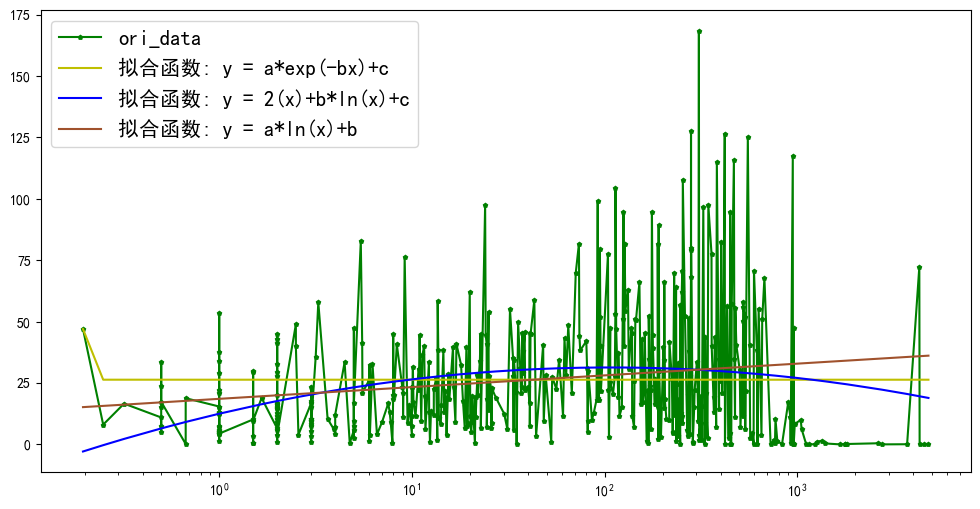

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

data_inform = pd.read_excel(r"./data/origin/表1-患者列表及临床信息.xlsx")
data_shuizhong = pd.read_excel(r"./data/origin/表2-患者影像信息血肿及水肿的体积及位置.xlsx")
data_time = pd.read_excel(r"./data/origin/附表1-检索表格-流水号vs时间.xlsx")
data_time = data_time[:100]
data_shuizhong = data_shuizhong[:100]
data_inform = data_inform[:100]
T0_time = data_time['入院首次检查时间点']
T_time = pd.DataFrame()
inter = data_inform['发病到首次影像检查时间间隔']
result = []
x = np.array([])

def time_interval(T0,T1):
    date1 = datetime.strptime(T0.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    date2 = datetime.strptime(T1.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    del_time = (date2 - date1).total_seconds()/3600 # 单位：小时
    return del_time

all_b = np.array([]) # 全体患者的水肿体积数据
all_c = np.array([]) # 全体患者的发病至影像检查时间
rule_b,rule_c = [],[]	#用于存储保存 all_c 和 all_b 数据，存入文档

for person in range(100):
    ED_volume = data_shuizhong.iloc[person]
    b = np.array([]) # 记录当前患者的各次随访的水肿体积 ED_volume 值
    c = np.array([]) # 记录当前患者的各次随访的发病至影像检查时间
    # 记录当前患者发病至首次影像检查时间及 ED_volume 值
    b = np.append(b, ED_volume['ED_volume'])
    c = np.append(c, inter[person])
    
    for i in range(8): # 最多 8 次随访
        T_time[str(i+1)] = data_time['随访'+str(i+1)+'时间点']
        v_1 = ED_volume['ED_volume.' + str(i + 1)]
        if pd.isnull(T_time[str(i+1)][person]):
            pass
        else:
            v_2 = -(inter[person] - time_interval(T0_time[person], T_time[str(i + 1)][person]))
    
            if v_2 >= 0: # 只记录随访时间在发病之后的值
                b = np.append(b, v_1)
                c = np.append(c, v_2)
            else: # 此次随访还未发病
                pass
    # 添加至全体患者数据中
    b = [x/1e3 for x in b]
    for v_b in b:
        all_b = np.append(all_b, v_b)
    for v_c in c:
        all_c = np.append(all_c, v_c)
    rule_b.append(b)
    rule_c.append(c)
merged_arr = np.column_stack((all_c, all_b))
    
# 排序
sorted_arr = merged_arr[np.argsort(merged_arr[:,0])]
all_b = sorted_arr[:,1] # 全体患者的水肿体积数据
all_c = sorted_arr[:,0]
pd.DataFrame(sorted_arr).to_excel('水肿体积与时间数据.xlsx')
# 作出一条全体患者水肿体积随时间进展曲线
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# plt.figure(figsize=(12, 6))
# plt.scatter(all_c, all_b, label='原始数据')
# plt.legend()
# plt.xlabel('发病至影像检查时间/小时',fontsize = 20)
# plt.ylabel('水肿体积 ED_volume/ml',fontsize = 20)
# plt.xticks(fontsize = 15 )
# plt.yticks(fontsize = 15)
# plt.title('全体患者水肿体积随时间进展曲线')
# plt.gca().set_xscale('log')
# plt.show()
from scipy.optimize import curve_fit
def func1(x, a, b, c):
    return a*np.exp(-b*x)+c
def func2(x, a, b, c):
    x = np.log(x)
    return a * x**2 + b*x + c
def func3(x, a, b):
    return a * np.log(x)+ b
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²:{r2:.2f}")

plt.figure(figsize=(12, 6))

xdata = all_c
ydata = all_b
print("--- raw data	")
print(len(xdata), len(ydata))
plt.plot(xdata, ydata, color = 'g', label='ori_data',marker="p",markersize=3)

print("--- curve1	")
popt, pcov = curve_fit(func1, xdata, ydata,maxfev = 80000)
ypred = func1(xdata, *popt)
evaluate_model(ydata, ypred, "Exponential function regression")
print("最优化参数:", popt)
plt.plot(xdata, func1(xdata, *popt), color = 'y' ,label='拟合函数: y = a*exp(-bx)+c')

print("--- curve2	")
popt, pcov = curve_fit(func2, xdata, ydata)
ypred = func2(xdata, *popt)
evaluate_model(ydata, ypred, "Power function regression")
print("最优化参数:", popt)
plt.plot(xdata, func2(xdata, *popt),color = 'b',label='拟合函数: y = 2(x)+b*ln(x)+c')

print("--- curve3	")
popt, pcov = curve_fit(func3, xdata, ydata)
ypred = func3(xdata, *popt)
evaluate_model(ydata, ypred, "Linear regression")
print("最优化参数:", popt)
plt.plot(xdata, func3(xdata, *popt),color = 'sienna',label='拟合函数: y = a*ln(x)+b')
plt.legend(fontsize = 15)

# 设置X轴为对数刻度
plt.xscale('log')

plt.show()

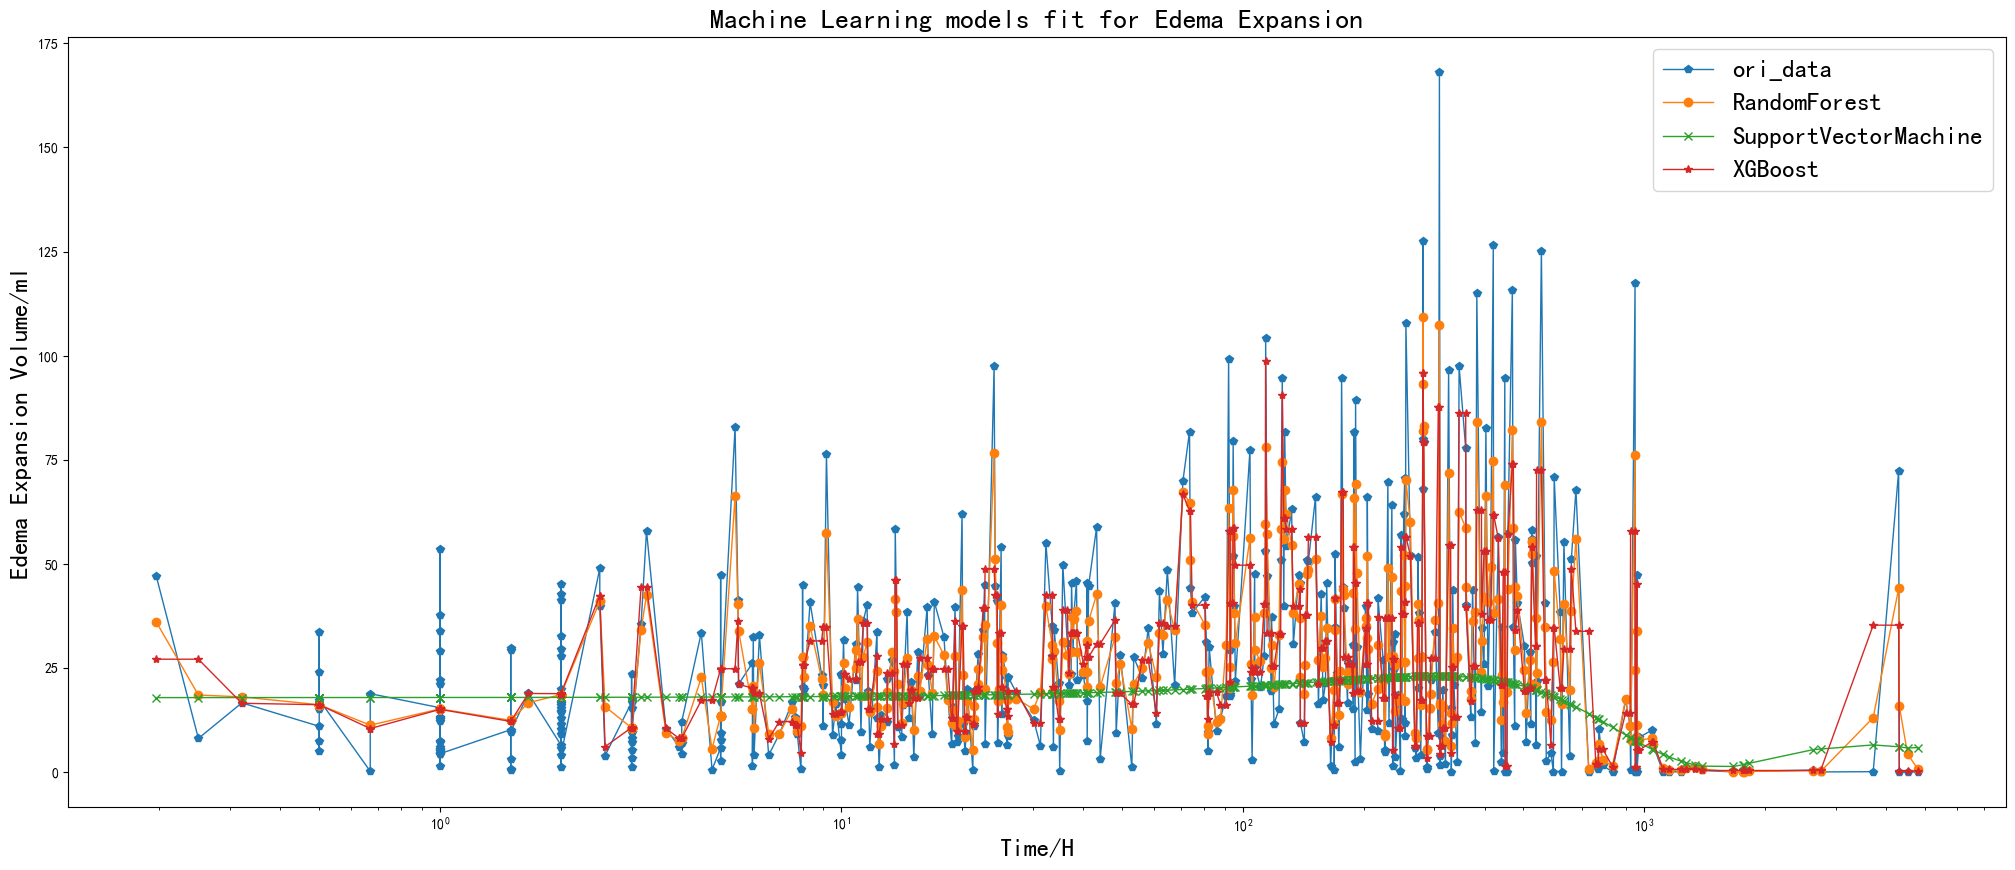

In [2]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

# xdata = X
# ydata = y

# RandomForest
RF_model = RandomForestRegressor(n_estimators=100, random_state=0)
RF_model.fit(xdata.reshape(-1, 1), ydata)
RF_pred = RF_model.predict(xdata.reshape(-1,1))


# SupportVectorMachine
SVM_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
SVM_model.fit(xdata.reshape(-1, 1), ydata)
SVM_pred = SVM_model.predict(xdata.reshape(-1,1))

# Xgboost
XGB_model = xgb.XGBRegressor() 
XGB_model.fit(xdata.reshape(-1,1),ydata)
XGB_pred = XGB_model.predict(xdata.reshape(-1,1))

plt.plot(xdata,ydata,linewidth=1,marker='p',label='ori_data')
plt.plot(xdata,RF_pred,linewidth=1,marker='o',label='RandomForest')
plt.plot(xdata,SVM_pred,linewidth=1,marker='x',label='SupportVectorMachine')
plt.plot(xdata,XGB_pred,linewidth=1,marker='*',label="XGBoost")

plt.legend(fontsize=18)
plt.gca().set_xscale('log')

plt.xlabel("Time/H",fontsize=18)
plt.ylabel("Edema Expansion Volume/ml",fontsize=18)
plt.title("Machine Learning models fit for Edema Expansion",fontsize=20)

plt.show()

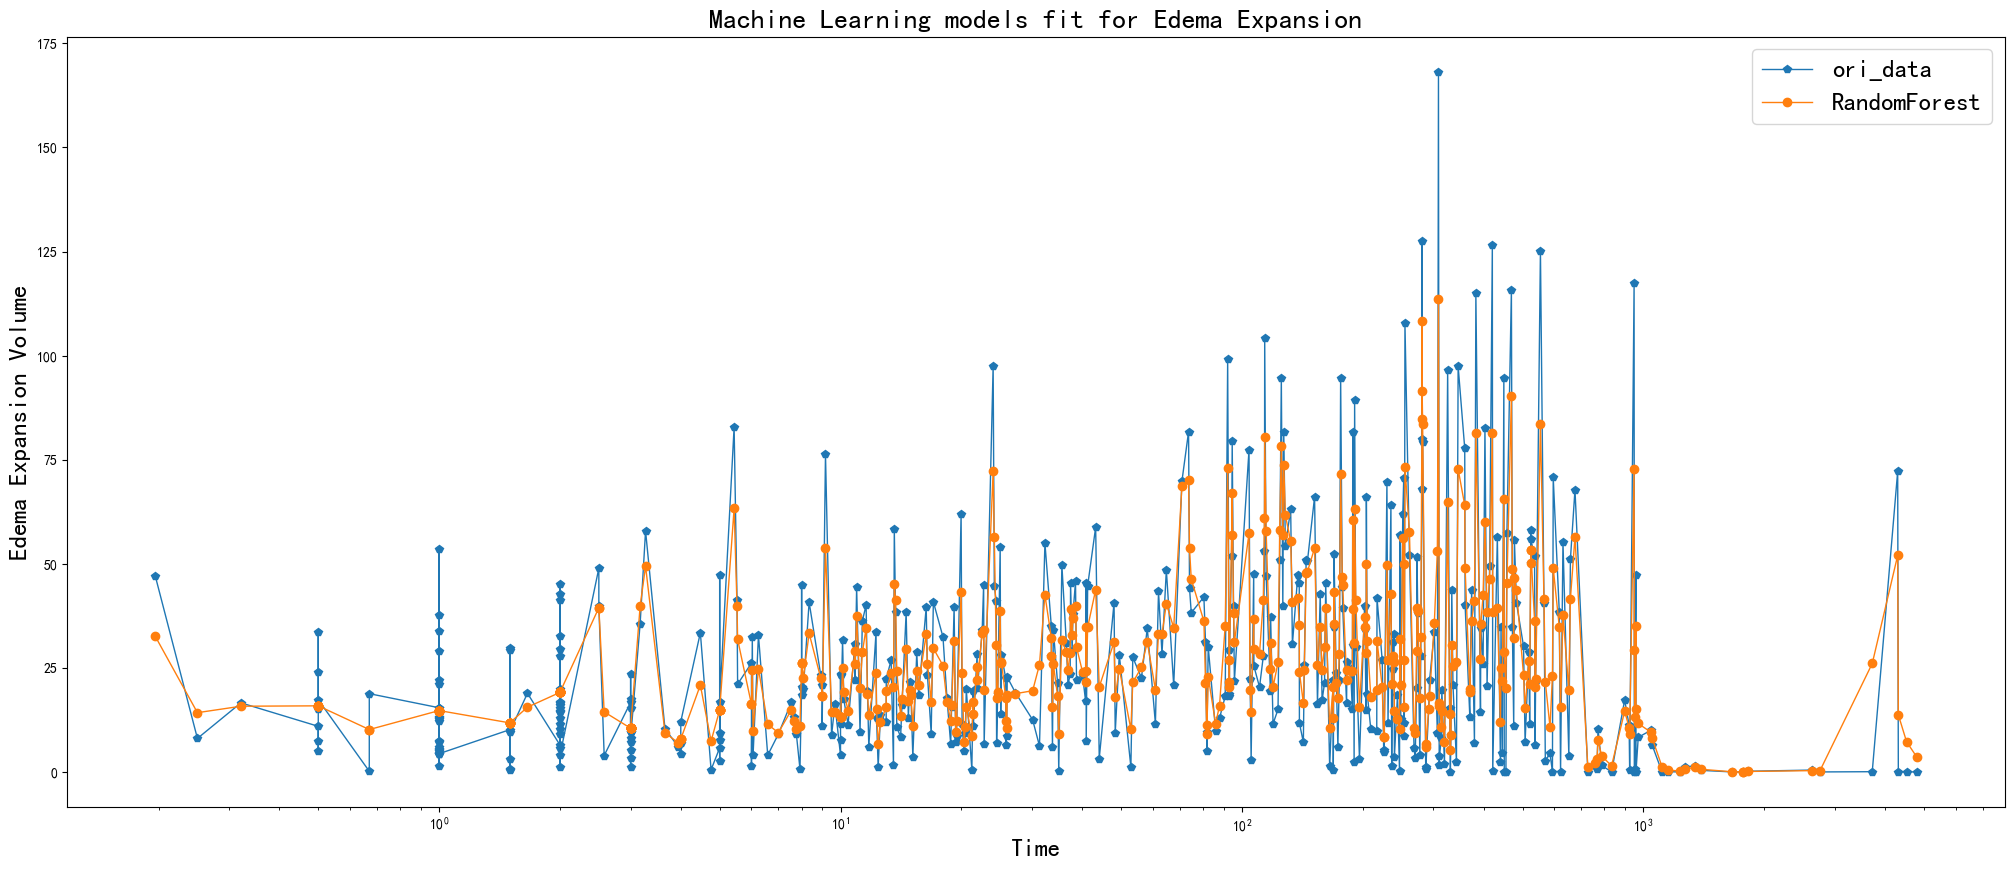

Random Forest模型的MAE: 8.949109178384058
Random Forest模型的MSE: 147.97615735597498
Random Forest模型的RMSE: 12.164545094493874
Random Forest模型的R²: 0.779625981682416
Support Vector Machine模型的MAE: 17.561889258532595
Support Vector Machine模型的MSE: 687.2491183227438
Support Vector Machine模型的RMSE: 26.215436641847944
Support Vector Machine模型的R²: -0.02348819226102461
XGBoost模型的MAE: 11.989196006560698
XGBoost模型的MSE: 307.0829453604405
XGBoost模型的RMSE: 17.523782278961367
XGBoost模型的R²: 0.5426756321081962


In [3]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

# RandomForest
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(xdata.reshape(-1, 1), ydata)
RF_pred = RF_model.predict(xdata.reshape(-1,1))

# 计算Random Forest模型的MAE、MSE、RMSE和R²
RF_MAE = mean_absolute_error(ydata, RF_pred)
RF_MSE = mean_squared_error(ydata, RF_pred)
RF_RMSE = np.sqrt(RF_MSE)
RF_R2 = r2_score(ydata, RF_pred)

# Support Vector Machine
SVM_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
SVM_model.fit(xdata.reshape(-1, 1), ydata)
SVM_pred = SVM_model.predict(xdata.reshape(-1,1))

# 计算Support Vector Machine模型的MAE、MSE、RMSE和R²
SVM_MAE = mean_absolute_error(ydata, SVM_pred)
SVM_MSE = mean_squared_error(ydata, SVM_pred)
SVM_RMSE = np.sqrt(SVM_MSE)
SVM_R2 = r2_score(ydata, SVM_pred)

# Xgboost
XGB_model = xgb.XGBRegressor(random_state=42) 
XGB_model.fit(xdata.reshape(-1,1),ydata)
XGB_pred = XGB_model.predict(xdata.reshape(-1,1))

# 计算XGBoost模型的MAE、MSE、RMSE和R²
XGB_MAE = mean_absolute_error(ydata, XGB_pred)
XGB_MSE = mean_squared_error(ydata, XGB_pred)
XGB_RMSE = np.sqrt(XGB_MSE)
XGB_R2 = r2_score(ydata, XGB_pred)

plt.plot(xdata,ydata,linewidth=1,marker='p',label='ori_data')
plt.plot(xdata,RF_pred,linewidth=1,marker='o',label='RandomForest')
# plt.plot(xdata,SVM_pred,linewidth=1,marker='x',label='SupportVectorMachine')
# plt.plot(xdata,XGB_pred,linewidth=1,marker='*',label="XGBoost")

plt.legend(fontsize=18)
plt.gca().set_xscale('log')

plt.xlabel("Time",fontsize=18)
plt.ylabel("Edema Expansion Volume",fontsize=18)
plt.title("Machine Learning models fit for Edema Expansion",fontsize=20)

plt.show()

print("Random Forest模型的MAE:", RF_MAE)
print("Random Forest模型的MSE:", RF_MSE)
print("Random Forest模型的RMSE:", RF_RMSE)
print("Random Forest模型的R²:", RF_R2)

print("Support Vector Machine模型的MAE:", SVM_MAE)
print("Support Vector Machine模型的MSE:", SVM_MSE)
print("Support Vector Machine模型的RMSE:", SVM_RMSE)
print("Support Vector Machine模型的R²:", SVM_R2)

print("XGBoost模型的MAE:", XGB_MAE)
print("XGBoost模型的MSE:", XGB_MSE)
print("XGBoost模型的RMSE:", XGB_RMSE)
print("XGBoost模型的R²:", XGB_R2)

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

data = pd.read_excel(r"./data/process/Q2C_data.xlsx")
data = data.iloc[:,1:]
X = data.iloc[:,:-1]

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

for i in range(data.shape[1]-1):
    contingency_table = pd.crosstab(data.iloc[:,i], data.iloc[:,-1])
    chi2, p, free, matrix = chi2_contingency(contingency_table)
    
    print("Chi-square statistic:", chi2)
    print("p-value:", p)
    print('n:',free)
    print('matrix:',matrix)


Chi-square statistic: 0.05963410218729362
p-value: 0.8070751941862092
n: 1
matrix: [[34.78 59.22]
 [ 2.22  3.78]]
Chi-square statistic: 0.018851194258065848
p-value: 0.8907939460173299
n: 1
matrix: [[ 7.77 13.23]
 [29.23 49.77]]
Chi-square statistic: 0.6172525909368008
p-value: 0.43207007631397076
n: 1
matrix: [[ 8.88 15.12]
 [28.12 47.88]]
Chi-square statistic: 1.3823606214910562
p-value: 0.23969945657482622
n: 1
matrix: [[ 2.96  5.04]
 [34.04 57.96]]
Chi-square statistic: 0.0008411773117655484
p-value: 0.9768621525370428
n: 1
matrix: [[ 5.55  9.45]
 [31.45 53.55]]
Chi-square statistic: 0.0
p-value: 1.0
n: 1
matrix: [[ 1.11  1.89]
 [35.89 61.11]]
Chi-square statistic: 0.00044687544687545326
p-value: 0.9831344323391066
n: 1
matrix: [[ 1.48  2.52]
 [35.52 60.48]]


[<built-in function array> 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0]
p-values: 0.8070751941862092
p-values: 0.8907939460173299
p-values: 0.43207007631397076
p-values: 0.23969945657482622
p-values: 0.9768621525370428
p-values: 1.0
p-values: 0.9831344323391066


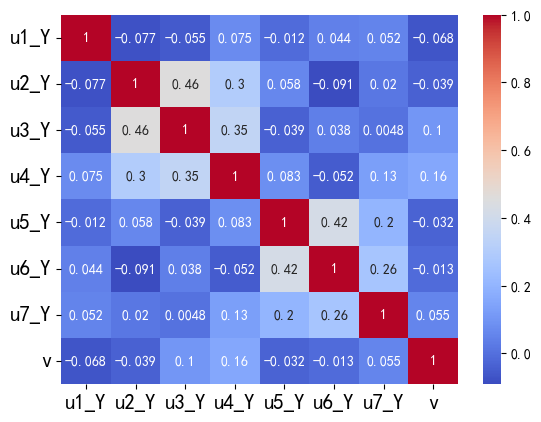

In [5]:
#------------------------------------------------时序性趋势预测
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def linear_func(x,a,b):
    return a*x+b

change = np.array

data = pd.read_excel(r"./data/process/Q2C.xlsx")
x = [1,2,3,4,5,6,7,8]
for i in range(100):
    tmp = np.array(data.iloc[:,i])
    tmp_cleaned = tmp[~np.isnan(tmp)]
    x_tmp = x[:len(tmp_cleaned)]

    popt,pcov = curve_fit(linear_func,x_tmp,tmp_cleaned)
    if popt[0]>0:
        change = np.append(change, 1)
    elif popt[0]<=0:
        change = np.append(change, 0)
print(change)
# ------------------------------------------------卡方验证
import numpy as np
import pandas as pd
data = pd.read_excel(r"./data/process/Q2C_data.xlsx")
data = data.iloc[:,1:]
X = data.iloc[:,:8]

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
from scipy.stats import f_oneway
for i in range(data.shape[1]-1):
    contingency_table = pd.crosstab(data.iloc[:,i], data.iloc[:,-1])
    _, p_val, _, _ = chi2_contingency(contingency_table)
    print("p-values:",p_val)
#-----------------------------------------------相关性分析
corr = X.corr()
# 绘制相关性图
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.xticks(rotation = 0,fontsize = 15)
plt.yticks(rotation = 0,fontsize = 15)
plt.show()
# #-----------------------------------------------Logistics回归模型
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd
# data = pd.read_excel(r"D:\workplace\Adobe\AC\破事\正在做\样例参考\Q2C_data.xlsx")
# data = data.iloc[:,1:]
# X = data.iloc[:,1:-1]
# y = data.iloc[:,-1]
# import warnings
# from sklearn.linear_model import LogisticRegression
# warnings.filterwarnings("ignore")

# for i in range(100):
#     # 创建 Logistic回归模型并拟合数据
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35,random_state=i)
#     # 创建 Logistic回归模型并拟合数据
#     model = RandomForestClassifier()
#     model.fit(X_train, y_train)
#     # 在测试集上进行预测
#     y_pred = model.predict(X_test)
#     # 计算准确率和混淆矩阵
#     acc = accuracy_score(y_test, y_pred)
#     cm = confusion_matrix(y_test, y_pred)
#     pre = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 =f1_score(y_test, y_pred)
    
#     print(cm,acc,pre,recall,f1,i)
#     # print(cm,i)

# sns.heatmap(cm, annot=True, fmt='d', cmap='cool', cbar=False)
# plt.show()

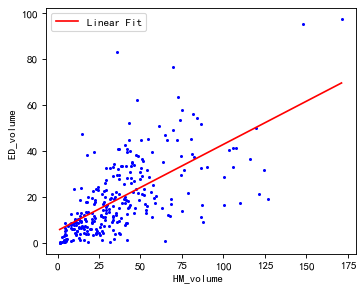

斜率 (slope): 0.3753675796689392
截距 (intercept): 5.306782110290989
相关系数 (r_value): 0.64678608240474
p 值 (p_value): 2.79190578787472e-35
标准误差 (std_err): 0.02626481957030844


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 读取数据
data = pd.read_excel(r"./data/process/Q2d.xlsx")
data.columns = (['x','y'])

# 将数据除以1000，将单位转换为千克
x = data['x']/1000
y = data['y']/1000

# 绘制散点图
plt.figure(figsize=(5,4),dpi=80)
plt.scatter(x, y, color='b', s=3)
plt.xlabel("HM_volume ")
plt.ylabel("ED_volume ")

# 进行线性拟合
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color='r', label='Linear Fit')

# 计算残差
residuals = y - (slope*x + intercept)

plt.legend()
plt.show()

print("斜率 (slope):", slope)
print("截距 (intercept):", intercept)
print("相关系数 (r_value):", r_value)
print("p 值 (p_value):", p_value)
print("标准误差 (std_err):", std_err)
